In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# !pip install fuzzywuzzy
# !pip install scikit-surprise

In [4]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV


In [5]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [6]:
movies = pd.read_csv('movies.csv')
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [8]:
movies['newId'] = range(1, movies['movieId'].nunique() + 1)

In [9]:
movies.head(3)

,movieId,title,genres,newId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,2
2,3,Grumpier Old Men (1995),Comedy|Romance,3


In [10]:
movie_ratings = pd.read_csv('ratings.csv')
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [11]:
movie_ratings['timestamp'] = movie_ratings['timestamp'].apply(lambda x : datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

In [12]:
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02
1,1,29,3.5,2005-04-02
2,1,32,3.5,2005-04-02
3,1,47,3.5,2005-04-02
4,1,50,3.5,2005-04-02


In [13]:
movie_ratings = movie_ratings.merge(movies, how = "left", on = "movieId")

In [14]:
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres,newId
0,1,2,3.5,2005-04-02,Jumanji (1995),Adventure|Children|Fantasy,2
1,1,29,3.5,2005-04-02,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,29
2,1,32,3.5,2005-04-02,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,32
3,1,47,3.5,2005-04-02,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,47
4,1,50,3.5,2005-04-02,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,50


In [15]:
movie_ratings.rename(columns = {"timestamp" : "date"}, inplace=True)

In [16]:
movie_ratings["movieId"] = movie_ratings['newId']
movies['movieId'] = movies['newId']

In [17]:
movie_ratings.drop(['newId'],axis=1, inplace=True)
movies.drop(['newId'], axis=1, inplace=True)

In [19]:
movie_ratings.sort_values(by="date", inplace=True)
movie_ratings.reset_index(drop=True, inplace=True)
# movies.sort_values(by="date", inplace=True)

In [20]:
print(movie_ratings.shape)
print(movie_ratings.columns)

(20000263, 6)
Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


Data Cleaning


In [21]:
movie_ratings.duplicated().sum()

0

No duplicates found

In [22]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [23]:
movie_ratings.isna().sum()

userId     0
movieId    0
rating     0
date       0
title      0
genres     0
dtype: int64

## EDA

#### Univariate Analysis

In [24]:
movie_ratings.head(2)

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


In [26]:
total_users = movie_ratings['userId'].nunique()
print(total_users)

138493


In [27]:
# Top 5 user id's 
movie_ratings['userId'].value_counts()[:5]

userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: count, dtype: int64

userId 118205 has around 9K records in the dataset.

In [29]:
# movieID
total_movies = movie_ratings['movieId'].nunique()
print("Total number of movies in dataset: ",total_movies)
print(f"Top 5 movies in dataset are: {movie_ratings['movieId'].value_counts()[:5]}")

Total number of movies in dataset:  26744
Top 5 movies in dataset are: movieId
294    67310
353    66172
316    63366
588    63299
477    59715
Name: count, dtype: int64


In [30]:
# To bring numerical values in Millions 
def changing_labels(number):
    return str(number/10**6) + "M"

Rating column

<Axes: xlabel='rating', ylabel='count'>

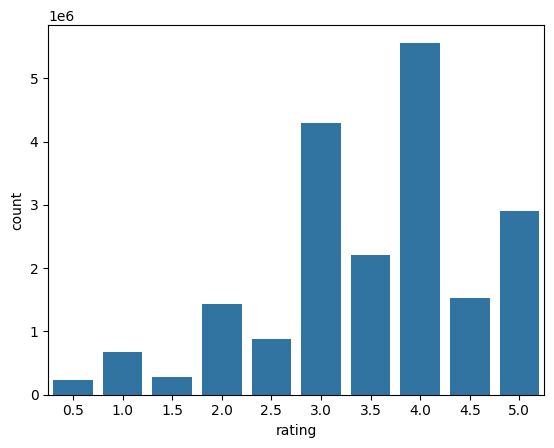

In [33]:
sns.countplot(x = "rating", data = movie_ratings)

<Axes: xlabel='rating'>

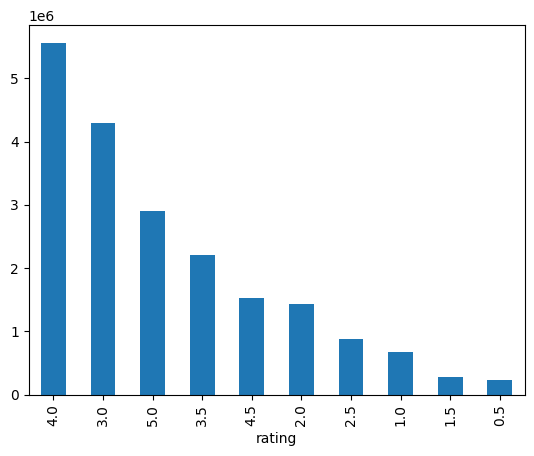

In [35]:
movie_ratings['rating'].value_counts().plot(kind='bar')

date column

In [36]:
print(f"Count of unique dates: {movie_ratings['date'].nunique()}")
print(f"First rating date: {movie_ratings['date'].min()}")
print(f"Last rating date: {movie_ratings['date'].max()}")
print(f"5 most common dates when ratings were given: {movie_ratings['date'].value_counts()[:5]}")

Count of unique dates: 6911
First rating date: 1995-01-09
Last rating date: 2015-03-31
5 most common dates when ratings were given: date
2000-11-20    91753
2005-03-22    76568
1999-12-11    65077
2008-10-29    55163
2000-11-21    54131
Name: count, dtype: int64


In [37]:
movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  26729
The top 5 title in the dataset are : 
 title
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: count, dtype: int64


In [39]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,12,1.0,1996-01-29,Dracula: Dead and Loving It (1995),Comedy|Horror


In [38]:
movie_ratings['genres']

0                              Comedy|Crime
1                          Mystery|Thriller
2                     Drama|Fantasy|Romance
3                     Comedy|Crime|Thriller
4                             Comedy|Horror
                         ...               
20000258           Animation|Comedy|Musical
20000259    Action|Adventure|Crime|Thriller
20000260          Action|Adventure|Thriller
20000261       Action|Adventure|Sci-Fi|IMAX
20000262                    Musical|Romance
Name: genres, Length: 20000263, dtype: object

In [40]:
unique_genres = {}
def extractGenres(x):
    for g in x.split("|"):
        if g not in unique_genres.keys():
            unique_genres[g]=1
        else:
            unique_genres[g] += 1
movie_ratings['genres'].apply(extractGenres)
print("Genres extracted from the text")

Genres extracted from the text


In [41]:
movie_ratings.head(2)

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


In [42]:
unique_genres

{'Comedy': 7502234,
 'Crime': 3298335,
 'Mystery': 1557282,
 'Thriller': 5313506,
 'Drama': 8857853,
 'Fantasy': 2111403,
 'Romance': 3802002,
 'Horror': 1482737,
 'Sci-Fi': 3150141,
 'Adventure': 4380351,
 'Children': 1669249,
 'Action': 5614208,
 'Animation': 1140476,
 'Musical': 870915,
 'War': 1048618,
 'Documentary': 244619,
 'Western': 423714,
 'IMAX': 492366,
 'Film-Noir': 216689,
 '(no genres listed)': 361}

In [44]:
genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns=["Genre", "Count"]
genres_df

,Genre,Count
0,Comedy,7502234
1,Crime,3298335
2,Mystery,1557282
3,Thriller,5313506
4,Drama,8857853
5,Fantasy,2111403
6,Romance,3802002
7,Horror,1482737
8,Sci-Fi,3150141
9,Adventure,4380351


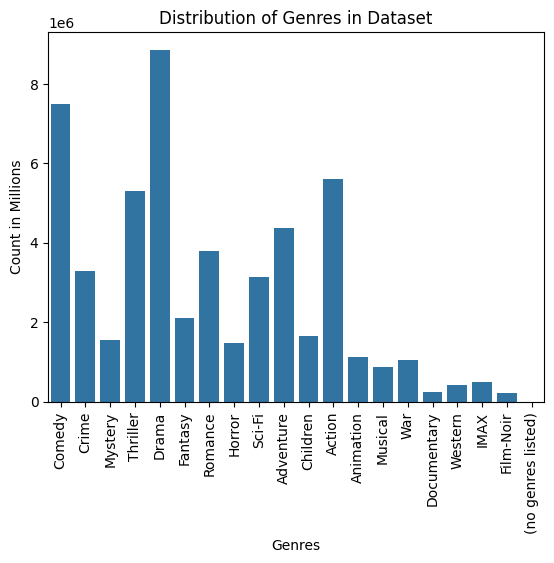

In [50]:
sns.barplot(x='Genre', y='Count', data=genres_df)
plt.title("Distribution of Genres in Dataset")
plt.xlabel("Genres")
plt.ylabel("Count in Millions")
plt.xticks(rotation = 90)
plt.show()

In [51]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,12,1.0,1996-01-29,Dracula: Dead and Loving It (1995),Comedy|Horror


In [52]:
from sklearn.model_selection import train_test_split

In [ ]:
Train_data, Test_data = train_test_split(movie_ratings, test_size=0.2, shuffle = False)

In [67]:
Train_Data = Train_data

In [63]:
Train_data.to_pickle("Train_data.pkl")

In [68]:
Test_Data = Test_data

In [69]:
# Create list of unique movies 

movie_list_in_training = Train_Data.drop_duplicates(subset = ['title'], keep = 'first')[['movieId', 'title', 'genres']]
movie_list_in_training = movie_list_in_training.reset_index(drop=True)
movie_list_in_training.head()

,movieId,title,genres
0,1058,"Fish Called Wanda, A (1988)",Comedy|Crime
1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,1154,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,21,Get Shorty (1995),Comedy|Crime|Thriller
4,12,Dracula: Dead and Loving It (1995),Comedy|Horror


In [70]:
# Checking the basic statistics for the training data

print("Total Train Data..")
print("Total number of movie ratings in train data : ", str(Train_Data.shape[0]))
print("Number of unique users in train data : ", str(len(np.unique(Train_Data["userId"]))))
print("Number of unique movies in train data : ", str(len(np.unique(Train_Data["movieId"]))))

Total Train Data..
Total number of movie ratings in train data :  16000210
Number of unique users in train data :  112470
Number of unique movies in train data :  12386


Bi variate Analysis